In [1]:
import warnings
from collections import Counter
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ctgan import CTGANSynthesizer
from sklearn.model_selection import train_test_split
from utils import *

MODELS_PATH = './models'
dataset = 'german'
seed = 1
np.random.seed(seed)

# A. Load data, preprocess, and calculate accuracy 

In [2]:
X, y, le = read_data(dataset)

In [3]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
categorical_features=[]
preprocessor = get_preprocessor(X, categorical_features)
rf = RandomForestClassifier(n_jobs=-1, random_state=seed)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', rf)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.770


# B. Plot confidence scores for all the data

In [4]:
X_train, y_train = X, y
clf.fit(X_train, y_train)
y_prob = rf.predict_proba(X_train)
y_conf_train = y_prob[:, 0]  # confidence scores

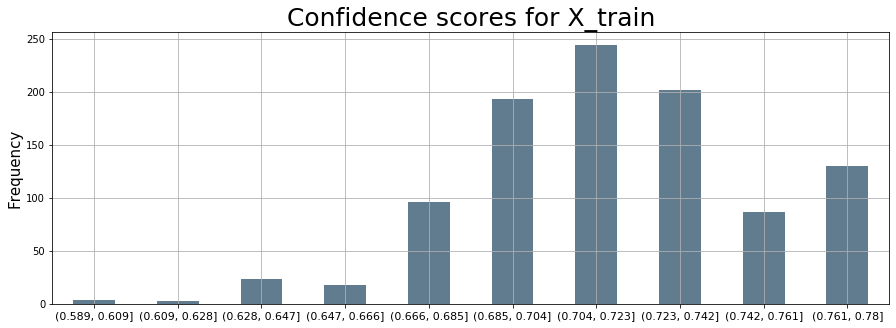

In [5]:
plot_confidence_levels(y_conf_train, "Confidence scores for X_train")

# C. Train CTGAN and plot the training loss

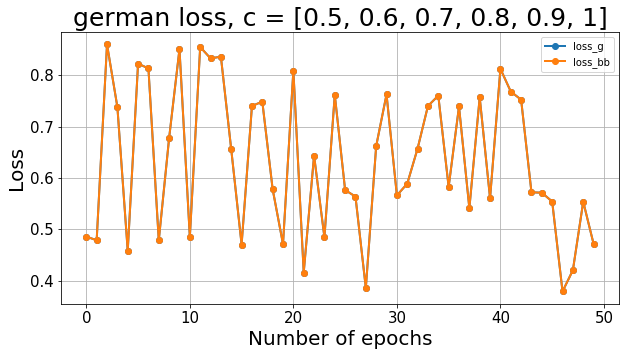

In [6]:
z_features = get_noise_features(X_train, categorical_features)
z_rows = int(0.25 * X_train.shape[0])
z = gen_random_noise(shape=(z_rows, z_features))

batch_size = 50
epochs = 50
confidence_level = [0.5, 0.6, 0.7, 0.8, 0.9, 1]
gen_lr = 2e-5
loss = 'log'

rf_ctgan = CTGANSynthesizer(batch_size=batch_size,
                            blackbox_model=rf,
                            preprocessing_pipeline=preprocessor,
                            bb_loss=loss
                            )

hist = rf_ctgan.fit(train_data=z,
                    epochs=epochs,
                    confidence_level=confidence_level,
                    gen_lr=gen_lr,
                    verbose=False
                    )

# rf_ctgan.save(f"{MODELS_PATH}/{dataset}_ctgan_c_{confidence_level}.pkl")

plot_losses(hist, title=f'{dataset} loss, c = {confidence_level}')
print()

# D. Plot confidence scores for generated samples 

In [7]:
# generate samples until you have the same number of samples as those
# of the training set and in the same confidence distribution
def gen_data_to_same_conf_dist_as_train(y_conf_gen, y_conf_train):
    train_bucktes = pd.value_counts(y_conf_train, bins=10, sort=False)
    idxs, freqs = train_bucktes.index, train_bucktes.values
    ans = []

    for sample_idx, sample_conf in enumerate(y_conf_gen):

        # find interval index which contains the sample_conf (-1 if not found)
        interval_idx = np.nonzero(idxs.contains(sample_conf))[0]

        # value not fould (empty list of indices)
        if len(interval_idx) == 0:
            continue 

        # check if the bucket is not full
        interval_idx = interval_idx[0]
        if freqs[interval_idx] > 0:
            ans.append(sample_idx)
            freqs[interval_idx] -= 1 
            
    return ans

In [8]:
samples = 100000

gen_data = rf_ctgan.sample(samples)
y_prob = rf.predict_proba(gen_data)
y_conf_gen = y_prob[:, 0]  # confidence scores

In [9]:
# ans is the indices of gen_data to make the same dist 
ans = gen_data_to_same_conf_dist_as_train(y_conf_gen, y_conf_train)

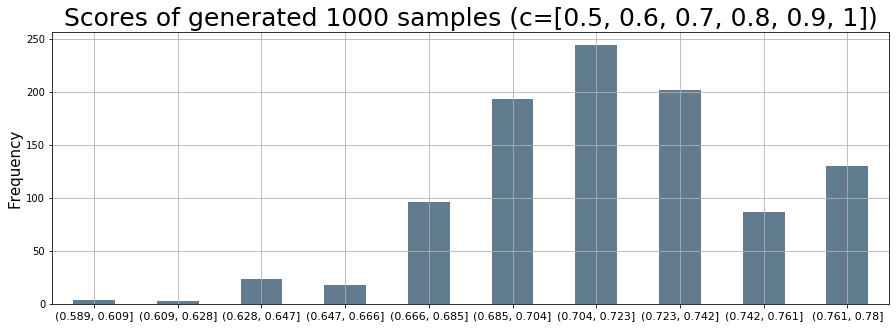

In [10]:
gen_data_same_dist = gen_data.iloc[ans]
y_conf_gen_same_dist = y_conf_gen[ans]

plot_confidence_levels(y_conf_gen_same_dist, f"Scores of generated {len(ans)} samples (c={confidence_level})")

# E. Select C as the middle of top frequent intervals

In [11]:
# Create bucket (intervals) from generated data
top_c = 3
conf_bucktes = pd.value_counts(y_conf_gen_same_dist, bins=10, sort=False)
idxs, freqs = conf_bucktes.index, conf_bucktes.values

# extract top_c intervals by frequency values
intervals_idxs = np.argsort(freqs)[::-1][:top_c]
top_c_intervals = idxs[intervals_idxs]

# create top_c_lst as the middle of the interval
top_c_lst = [(interval.right + interval.left)/2 for interval in top_c_intervals]

### Train CTGAN with the selected C

In [12]:
y_conf_gen = y_conf_gen_same_dist
gen_data = gen_data_same_dist


c = top_c_lst[0]
rf_ctgan = CTGANSynthesizer(batch_size=batch_size,
                            blackbox_model=rf,
                            preprocessing_pipeline=preprocessor,
                            bb_loss=loss
                            )

hist = rf_ctgan.fit(train_data=z,
                    epochs=epochs,
                    confidence_level=c,
                    gen_lr=gen_lr,
                    verbose=False
                    )

# F. Evaluation

In [13]:
# inverse the generated data
scaler = get_scaler(preprocessor)
gen_data_inv = scaler.inverse_transform(gen_data)
gen_data_inv = pd.DataFrame(gen_data_inv)

In [14]:
### extract similar examples from each sample in gen data
# similarities dict: gen_sample_above_c -> (most_similiar_sample_x_train, cosine_score)
similarities = calc_similarities(gen_data_inv, X_train)

# Calculate coverage for each similarity threshold

In [15]:
similarity_thresholds = [0.8, 0.85, 0.9, 0.95, 0.99]
data = []
for threshold in similarity_thresholds:
    count = 0
    for gen_idx, (most_similiar_x_train_idx, cosine_score) in similarities.items():
        if cosine_score >= threshold:
            count += 1
    coverage = (count / gen_data_inv.shape[0]) * 100
    data.append([threshold, round(coverage)])

In [16]:
columns = ['Cosine threshold', 'Coverage']
results = pd.DataFrame(data, columns=columns)
print(f"CTGAN with confidence level = {c}")
display(results)

CTGAN with confidence level = 0.7135


,Cosine threshold,Coverage
0,0.80,92
1,0.85,90
2,0.90,87
3,0.95,81
4,0.99,55
